## Purpose: A prediction model for quantity over the life of a quote that will generalize to inputs beyond the range of the training dataset.  Generalization is required to test new pricing potential.  

### This model is designed to work with sparse data and high granularity.  In this case, granulaty is from many part numbers in combination with many customers with intermittent purchases.  No complete time sequences exist due the granularity.  It can be applied to retail and distribution models as well as demand planning systems.

### The application specifically addressed is pricing at the time of quote.  The quantity foreast is by quote for a period of twelve months after the first shipment against the quote.  The quotes are issued by a pricing team who seek to maximize the rates of close (a 'win') when the quote results in a shipment and the total shipments over the 12 month life of the quote.

#### Libraries and Utilities

In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#allow cell to perform multiple computations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#set cell width as percentage of window

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from tensorflow.keras.backend import clear_session
clear_session()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import math
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn_pandas import DataFrameMapper 
import os as os
import string
from joblib import dump, load
import time
import gc

In [7]:
# subdirectories for quantity rate models
!mkdir quantity_val_checkpoint
!mkdir quantity_all_checkpoint
!mkdir quantity_all_model
!mkdir quantity_maps
!mkdir quantity_val_model

In [8]:
# DOMAIN KNOWLEDGE:  ship_date is date of a shipment ordered from a valid quote
# DOMAIN KNOWLEDGE:  there can be multiple shipments (i.e., multiple ship_date's) against a quote while order is valid
# DOMAIN KNOWLEDGE:  quotes are open for ninety days and require a shipment to remain valid
# DOMAIN KNOWLEDGE:  quotes remain valid for one year after first ship_date
# DOMAIN KNOWLEDGE:  Win is a quote with a shipment against the quote while quote is in 90 day open period
# DOMAIN KNOWLEDGE:  Capture is ratio of total quantity shipped to quantity quoted

### Load Data

In [9]:
# Load features and targets
dx = load('Order_Ship_Data')

# Definitions:
#   'quote' is a unique number assigned to every quote; more than one item can be included on a quote number
#   'part' is the part name being quoted
#   'plant' is the company division that manufactures the part
#   'dist' is a unique number assigned to the company distributors
#   'region' is the customer region location
#   'quote_qty' is the requested quote amount
#   'sales_qty' is the quantity shipped on the 'ship_date'; there can be multiple shipments against a quote
#   'quote_price' is the price first quoted; shipping prices can vary from competitive requirements
#   'ship_date' are the dates of shipment
#   'quote_date' is the date of the quote
#   'Win' is whether or note quote closed: 1 = closed, 0 = lost
#   'Quote_Yr' is year of quote issue
#   'Quote_Mon' is month of year quote issued
#   'Quote_Qtr' is quarter of year quote issued
#   'Close_Date' is date quote expires 1 year after first shipment
#   'Months_Used' is number of months passed in year to the quote closing date 


## Build Quantity Shipment Predictor
#### Encode, scale and shape data for tensorflow
#### Perform train test split

In [10]:
# Libraries needed

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn_pandas import DataFrameMapper
from tensorflow.keras.backend import clear_session
from tensorflow import keras
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, concatenate, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import mae, mse

In [11]:
# Choose categorical feature vars
# Include 'Win' as categorical feature so that the 0 entry in Win can explain the 0 sales quantity
cat_vars = ['part', 'plant', 'dist', 'region']

# Choose time features vars
time_vars = ['Quote_Yr', 'Quote_Mon', 'Quote_Qtr','Months_Used']

# Choose continuous feature vars to be scaled with minmax, robust, or standard scalers
cont_vars = ['quote_qty','quote_pr']

# Choose continuous feature vars to be logged and then scaled
cont_vars_log = ['quote_qty']

# Choose target features
targets = ['sales_qty']

# Append features
features = cat_vars + time_vars + cont_vars

# Identify data and target dataframes
data = dx[features]
target = dx[targets]


### Apply encoders, embeddings, max/min embeddings and scalers to feature data

#### Apply logs to variables and targets with excesssive range

In [12]:
#  Take log on continuous features to be logged to reduce range
def log_cont_data(data, cont_vars_log=cont_vars_log):
    
    # take logs of each variable to be logged identified
    for feat in cont_vars_log:
        data[feat] = data[feat].apply(lambda x: np.log(x).astype(np.float32))
    
    # return data with logged columns
    return data

# insert logs into data
data = log_cont_data(data)

In [13]:
#  Take log on target to reduce range
def log_target(target=target,targets=targets):
    
    # take log of targets in target
    target[targets] = target[targets].apply(lambda x: np.log(x).astype(np.float32))
    
    # return logged target 
    return target

# insert logs into data
y = log_target()

### Compute list of embedding sizes and tuples of label encoders

In [14]:
# Function to apply embeddings for categorical features in data

def cat_map_data(data,cat_vars=cat_vars, emax=50, emin=4):
    # compute list of number of unique categories for each categorical variable
    cat_emb = [len(data[c].unique()) for c in cat_vars]
    
    # compute list inserting maximum number of embeddings for each category 
    cat_emb_max = [c if c<= emax else emax for c in cat_emb] #maximum embedded weights is emax (default=50)
    
    # compute list inserting minimum number of embeddings for each category
    cat_emb_max = [c if c>= emin else emin for c in cat_emb_max] #minimum embedded weights is emin (default = 4)
    
    # form dictionary of the categorical variables and the list of embeddings
    cat_vars_dict = dict(zip(cat_vars,cat_emb_max))
    
    # form list of tuples of categorical variables and the label encoder
    cat_map = [(c,LabelEncoder()) for c in cat_vars]
    
    # return the embedding dictionary and the map of label encoders to categorical variables
    return cat_vars_dict,cat_map

In [15]:
# Function to apply embeddings for time features in data

def time_map_data(data,time_vars=time_vars, tmax=12, tmin=3):
    
    # compute number of unique values for each time variable
    time_emb = [len(data[t].unique()) for t in time_vars]
    
    # insert maximum embedded coefficients for time variables
    time_emb_max = [t if t <= tmax else tmax for t in time_emb] #maximum embedded weights is tmax (default=12)
    
    # insert minimum embedded coefficients for time variables
    time_emb_max = [t if t >= tmin else tmin for t in time_emb_max]#minimum embedded weights is tmin (default=3)
    time_vars_dict = dict(zip(time_vars,time_emb_max))
    
    # compute list of tuples assigning the Label Encoder to the time variable
    time_map = [(t,LabelEncoder()) for t in time_vars]
    
    # return dictionary of embedded coefficients and list of encoder tuples
    return time_vars_dict,time_map

In [16]:
# Function to apply scaler on the continuous features in data
# s can be standardscaler,robustscaler or minmaxscaler; default is minmax
# x,y is limit on minmax; default to 0,1
# l,u is percential rank for the robust scaler based on median; default is 10,90

def cont_map_data(cont_vars=cont_vars, s='minmax', x=1, y=2, l=10, u=90): # s can be standardscaler,robustscaler or minmaxscaler
    
    # select scaler map and form list of tuples for variable and scaler
    if s == 'standard':
        cont_map = [([c],StandardScaler(copy=True,with_mean=True,with_std=True)) for c in cont_vars]
    
    elif s == 'robust':
        cont_map = [([c],RobustScaler(with_centering=True,with_scaling=True,quantile_range=(t,u))) for c in cont_vars]
    
    elif s == 'minmax':
        cont_map = [([c],MinMaxScaler(feature_range = (x,y))) for c in cont_vars]
    
    # return map of scaler and continuous variables tuples
    return cont_map

### Transform feature variables and convert to array using DataFrameMapper

In [17]:
# Encode categorical features amd fit - transform with DataFrameMapper
def map_cat_data(data):
    
    # map encoder to categorical variables; cat_vars_dict required for input layers
    cat_vars_dict,cat_map = cat_map_data(data)
    
    # initialize dataframe mapper
    cat_mapper = DataFrameMapper(cat_map)
    
    # fit categorical variables; cat_map_fit required for input layer
    cat_map_fit = cat_mapper.fit(data)
    
    # transform data using dataframe mapper
    cat_data = cat_map_fit.transform(data).astype(np.int64) 
    
    # return cat_vars_dict and cat_map_fit used in embedding input layer to tensorflow
    return  cat_data, cat_vars_dict, cat_map_fit 

In [18]:
# Encode time features and fit - transform with DataFrameMapper    
def map_time_data(data):    
    
    # map encoder to time variables; time_vars_dict used in embedding input layer to tensorflow
    time_vars_dict,time_map = time_map_data(data)
    
    # initialize dataframemapper
    time_mapper = DataFrameMapper(time_map)
    
    # fit time variables to data; time_map_fit req'd for input layers
    time_map_fit = time_mapper.fit(data)
    
    # transform data
    time_data = time_map_fit.transform(data).astype(np.int64)
    
    # return encoded time data, time_vars_dict and time_map_fit used in input layer
    return time_data, time_vars_dict, time_map_fit 

In [19]:
# Scale continuous features and fit with DataFrameMapper
def map_cont_data(data):
    
    # map scaler to continuous data;  cont_map_data defaults to comt_vars and minmax scaler, x = 0,y = 1
    cont_map = cont_map_data() 
    
    # intialize DataFrameMapper with scalers to be applied
    cont_mapper = DataFrameMapper(cont_map)
    
    # fit mapper to data; cont_map_fit is required when building input layers
    cont_map_fit = cont_mapper.fit(data)
    
    # transform and return data
    cont_data = cont_map_fit.transform(data).astype(np.float32)
    
    return cont_data, cont_map_fit

In [20]:
# Compute transformed and shaped input data
# scale and encode data - ?_vars_dict and ?_map_fit used in building input layers

# encode categorical variables
data_cat, cat_vars_dict, cat_map_fit = map_cat_data(data)

# encode time variables
data_time, time_vars_dict, time_map_fit = map_time_data(data)

# scale selected continuous variables
data_cont, cont_map_fit = map_cont_data(data)

# concatenate encoded, scaled and logged and scaled data
data_scaled = np.hstack([data_cat,data_time,data_cont])


#### When scaling the target variable using minmax do not use a range of 0,1.  The mape metrics and losses are not usable with that range.  Since we are not directly using L1 or L2 regularization the mean and unit variance has no purpose.

In [21]:
# Function to scale and shape continuous variable target tensor
def map_cont_target(y, s='minmax', f=1, c=2, l=10, u=90):     

    # select scaler    
    if s == 'standard':
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

        # fit scaler to column
        scaled = scaler.fit(y)

        # save scaler to quantity_maps subdirectory   
        filename = os.path.join('quantity_maps','target_cont_scaler')
        dump(scaled,filename)

        # transform target
        y_scaled = scaled.transform(y)
    
    elif s == 'robust':
        scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(l,u))

        # fit scaler to target
        scaled = scaler.fit(y)

        # save scaler to quantity_maps subdirectory   
        filename = os.path.join('quantity_maps','target_cont_scaler')
        dump(scaled,filename)

        # transform target
        y_scaled = scaled.transform(y)

    # note:applying minmax scaler to log removes need for leakyRelu in model
    elif s == 'minmax':
        scaler = MinMaxScaler(feature_range=(f,c))

        # fit scaler to column
        scaled = scaler.fit(y)

        # save scaler to quantity_maps subdirectory   
        filename = os.path.join('quantity_maps','target_cont_scaler')
        dump(scaled,filename)

        # transform target
        y_scaled = scaled.transform(y)
    
    # shape and type y array for tensorflow
    y_scaled = np.array(y_scaled).reshape(-1,1).astype(np.float32) 
    
    return y_scaled

# scale target vector y
y_scaled = map_cont_target(y)

### Functions to identically encode categorical and time data and save for use in predictions
### Function to identically scale continuous data and save for use in predictions

In [22]:
# Build maps of categorical and time features and save encoded labels for prediction scheme
# Scale and save scaler on continuous features for prediction scheme

# function to map the encoding to the categories and save in win_maps subdirectory
# colname is in string format
def encode_cat(data,data_cat,colname):
    colnum = data.columns.get_loc(colname)
    label_map = dict(zip(data[colname],data_cat[:,colnum]))
    filename = os.path.join('quantity_maps',colname + '_cat_label_map')
    dump(label_map,filename)
    return colnum

# function to map the encoding to time features and save in win_maps subdirectory
# colname is in string format
def encode_time(data,data_time,colname,catnum):
    colnum = data.columns.get_loc(colname)-(catnum + 1)
    label_map = dict(zip(data[colname],data_time[:,colnum]))
    filename = os.path.join('quantity_maps',colname + '_time_label_map')
    dump(label_map,filename)
    return

# function to calculate scalers on continuous features and save in capture_maps subdirectory
def scale_conts(data,colname,s):
     # select scaler
    if s == 'standard':
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    elif s == 'robust':
        scaler = RobustScaler(with_centering=True,with_scaling=True,quantile_range=(20,80))
    elif s == 'minmax':
        scaler = MinMaxScaler(feature_range=(1,2))
    
    # fit scaler to column
    scaled = scaler.fit(np.array(data[colname]).reshape(-1,1))
    
    # save scaler to win_maps subdirectory   
    filename = os.path.join('quantity_maps',colname + '_cont_scaler')
    dump(scaled,filename)
    
    return
    

for colname in cat_vars:catnum=encode_cat(data,data_cat,colname)
for colname in time_vars:encode_time(data,data_time,colname,catnum)
for colname in cont_vars:scale_conts(data,colname,'minmax')


### Split data in training, validation and test sets.
#### Construct stratification method based on percentiles

In [23]:
# Sold quantity, the target, is binned into 4 percentiles 0,.25, .5, .75, 1
# The bins are then used to stratify the train,validation and test splits
# The bins are NOT used in the training or test but only to balance the split

In [24]:
# Compute stratification array and percentile boundaries
strats, percentiles = pd.qcut(y_scaled.reshape(-1,),4,labels=False,retbins=True)

# Store percentile boundaries for prediction scheme
filename = os.path.join('quantity_maps','stratify_percentiles')
dump(percentiles,filename)

# Concatenate y_scaled with strats so the split includes stratification
y = np.column_stack((y,strats))

# Perform first split to obtain stratified all and test set 
data_all,data_test,y_all,y_test = train_test_split(data_scaled,y,test_size=.05,random_state=75,stratify=strats)

# Redefine strats to be stratification in remaining target vector y_all; remove strats from y_all
strats = y_all[:,1]
y_all = y_all[:,0]

# Perform second split to obtain stratified train and validation sets 
data_train,data_val,y_train,y_val = train_test_split(data_all,y_all,test_size=.15,random_state=75,stratify=strats)

# Convert train and test input data to list of arrays for tensorflow
X_train = np.hsplit(data_train, data_train.shape[1])
X_val = np.hsplit(data_val, data_val.shape[1])
X_test = np.hsplit(data_test, data_test.shape[1])
X_all = np.hsplit(data_all, data_all.shape[1])

# Shape targets
y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)
y_test =  np.array(y_test[:,0]).reshape(-1,1)
y_all = np.array(y_all).reshape(-1,1)



['quantity_maps/stratify_percentiles']

#### Apply split twice for validation and test

###  Compute sample weights on  data for tensorflow fitting method 

In [25]:
# colname is column name string for column setting weights

def sample_weights(data,colname,features=features,hi=2,lo=1): #data input is the training array before conversion to list
    
    # convert array to dataframe
    df = pd.DataFrame(data,columns=features)
    df.head()
    
    # compute unique value counts
    weights = df[colname].value_counts(normalize=True, ascending = False)
    weights = pd.DataFrame(weights).reset_index()
    weights.columns = [colname,'share']
    
    # create array of weights in descending order
    weight = np.array(weights.share).reshape(-1,1)
    
    # minmaxscaler on weights to offset decrease in loss from small weights
    weight = MinMaxScaler(feature_range=(lo,hi)).fit_transform(weight)
    
    # convert to list and reverse order
    weight = list(weight)
    weight.reverse()
    
    # compute dictionary of unique items in colname and reversed weights
    weight_dict = dict(zip(weights[colname],weight))
    
    # compute weights on data and convert to np array
    weight_arr = np.array([weight_dict[x] for x in df[colname]]).reshape(-1,)
    
    # return array mapping colname items to reversed weights
    return weight_arr

In [26]:
# compute weights on part numbers in data_train
train_weight = sample_weights(data_train,'part')
all_weight = sample_weights(data_all, 'part')

## Build Sales Quantity Predictive Model

In [27]:
# Graph categorical features input layers
# Initialize with Xavier by calling 'glorot_normal' to minimize vanishing/exploding gradients
# Apply batch normalization for both regularization and controlling gradients
# Apply dropout to control overfitting

def cat_input(feat,cat_vars_dict,r=.5):
    # compute input vector
    name = feat[0]
    c1 = len(feat[1].classes_)
    c2 = cat_vars_dict[name]

    # create input layer
    inp = Input(shape=(1,),dtype='int64',name=name + '_in')
    cat = Flatten(name=name+'_flt')(Embedding(c1,c2,input_length=1)(inp))
    
    # add dense layers, dropout, and batch normalization
    cat = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cat)
    cat = Dropout(rate=r)(cat)
    cat = BatchNormalization()(cat)
    cat = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cat)
    cat = Dropout(rate=r)(cat)
    cat = BatchNormalization()(cat)
    return inp,cat

# Graph categorical features input
cats = [cat_input(feat,cat_vars_dict) for feat in cat_map_fit.features]

In [28]:
# Graph time input layers

def time_input(feat,time_vars_dict,r=.5):
    
    # compute input vector
    name = feat[0]
    c1 = len(feat[1].classes_)
    c2 = time_vars_dict[name]

    # create input layer
    inp = Input(shape=(1,),dtype='int64',name=name + '_in')
    time = Flatten(name=name+'_flt')(Embedding(c1,c2,input_length=1)(inp))
    
    # add dense, dropout and normalization layers
    time = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(time)
    time = Dropout(rate=r)(time)
    time = BatchNormalization()(time)
    time = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(time)
    time = Dropout(rate=r)(time)
    time = BatchNormalization()(time)
    return inp,time

# Graph time features input
times = [time_input(feat,time_vars_dict) for feat in time_map_fit.features]

In [29]:
# Graph input layers for continuous features

def cont_input(feat,r=.5):
    name = feat[0][0]
    
    # create input layer
    inp = Input((1,), name=name+'_in')
    cont = Dense(1, name = name + '_d')(inp)

    # add dense, dropout, batch normalization layers
    cont = Dense(1000, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cont)
    cont = Dropout(rate=r)(cont)
    cont = BatchNormalization()(cont)
    cont = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(cont)
    cont = Dropout(rate=r)(cont)
    cont = BatchNormalization()(cont)
    return inp,cont

# Graph continuous features input
conts = [cont_input(feat) for feat in cont_map_fit.features]


In [30]:
def build_quantity_model(cats, times, conts, r = .5):

    # Build graph for interconnected categorical features
    
    # input concatenated categorical features for interconnected nodes
    c = concatenate([cat for inp,cat in cats])
    
    # add dense, dropout and batch normalization layers
    c = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(c)
    c = Dropout(rate=r)(c)
    c = BatchNormalization()(c)
    c = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(c)
    c = Dropout(rate=r)(c)
    c = BatchNormalization()(c)
    
    # Build graph for concatenated time features for interconnected nodes
    
    # concatenate time variables for inteconnected nodes
    t = concatenate([time for inp,time in times])
    
    # add dense, dropout and batch normalization layers 
    t = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(t)
    t = Dropout(rate=r)(t)
    t = BatchNormalization()(t)
    t = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(t)
    t = Dropout(rate=r)(t)
    t = BatchNormalization()(t)

    # Build graph for continuous features fully interconnected by concatenate
    
    # concatenate if 2 or more variables
    if len(conts)>1: f = concatenate([cont for inp,cont in conts])
    else: f= conts[0][1]

    # add dense, dropout and batch normalization layers fully interconnected
    f = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(f)
    f = Dropout(rate=r)(f)
    f = BatchNormalization()(f)
    f = Dense(500, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(f)
    f = Dropout(rate=r)(f)
    f = BatchNormalization()(f)
    
    # Concatenate categorical, time, continuous and continuous logged features
    x = concatenate([c,t,f])

    # add fully interconnected dense, dropout and normalization layers
    x = Dense(500,activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(x)
    x = Dropout(rate=r)(x)
    x = BatchNormalization()(x)
    x = Dense(500,activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(x)
    x = Dropout(rate=r)(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='relu',kernel_initializer='glorot_normal',bias_initializer='normal')(x) 
    
    # add input layer for the model
    model = Model([inp for inp,cat in cats] + [inp for inp,time in times] + [inp for inp,cont in conts], x)
    
    #  compile with optimizer, loss and metrics
    model.compile(optimizer='Adam', loss = MSE, metrics = ['mae','mse'])
    
    return model

In [31]:
quantity_model = build_quantity_model(cats, times, conts)

In [32]:
# save a text copy of quantity_model 
#filename = os.path.join('quantity_maps','quantity_model_')
#with open(filename + 'report.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
#    quantity_model.summary(print_fn=lambda x: fh.write(x + '\n'))

In [33]:
# plot and save quantity model
#filename = os.path.join('quantity_maps','quantity_model.png')
#plot_model(quantity_model, filename, show_shapes=True)

In [34]:
# Initialize callbacks

es = EarlyStopping(monitor='loss', patience=5, verbose=0,
    mode='auto', min_delta=.015, restore_best_weights=True)

rlr = ReduceLROnPlateau(monitor='loss', factor=0.85,
                              mode = 'min', min_delta=.01, patience=2, min_lr=0.0005)
filepath = 'quantity_checkpoint'
mckp = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch')

In [35]:
# Train the model using early stopping and reducing learning rates to reduce overfitting and 'memorization'.

quantity_model.fit(X_train,y_train,
            batch_size=64,
            epochs=30,
            verbose=True,
            validation_data = (X_val, y_val), sample_weight = train_weight,
            callbacks=[es,rlr,mckp])

Train on 4061 samples, validate on 717 samples
Epoch 1/30
4061/4061 [==============================] - 21s 5ms/sample - loss: 97.0974 - mae: 8.9795 - mse: 91.4218 - val_loss: 5.5183 - val_mae: 1.9607 - val_mse: 5.5183
Epoch 2/30
4061/4061 [==============================] - 8s 2ms/sample - loss: 46.8600 - mae: 5.2894 - mse: 44.0478 - val_loss: 20.0897 - val_mae: 4.0620 - val_mse: 20.0897
Epoch 3/30
4061/4061 [==============================] - 8s 2ms/sample - loss: 20.4684 - mae: 2.9976 - mse: 19.1980 - val_loss: 8.1436 - val_mae: 2.3354 - val_mse: 8.1436
Epoch 4/30
4061/4061 [==============================] - 8s 2ms/sample - loss: 17.3166 - mae: 2.6324 - mse: 16.2791 - val_loss: 7.1032 - val_mae: 2.1687 - val_mse: 7.1032
Epoch 5/30
4061/4061 [==============================] - 8s 2ms/sample - loss: 15.4881 - mae: 2.4394 - mse: 14.5341 - val_loss: 4.0944 - val_mae: 1.6031 - val_mse: 4.0944
Epoch 6/30
4061/4061 [==============================] - 8s 2ms/sample - loss: 12.6487 - mae: 2.1370 

,loss,mae,mse,val_loss,val_mae,val_mse,lr
0,97.097374,8.979527,91.421837,5.518292,1.960679,5.518291,0.001
1,46.859964,5.289447,44.047821,20.089675,4.061954,20.089674,0.001
2,20.468434,2.997552,19.197954,8.143596,2.335359,8.143595,0.001
3,17.316557,2.632395,16.279146,7.103186,2.168734,7.103185,0.001
4,15.488128,2.439391,14.534078,4.094400,1.603060,4.094400,0.001


,loss,mae,mse,val_loss,val_mae,val_mse,lr
25,2.452472,1.053673,2.297906,3.138505,0.916123,3.138505,0.001
26,2.345233,1.048987,2.203529,2.980256,0.901129,2.980256,0.001
27,2.397851,1.047766,2.255699,3.206138,0.933817,3.206138,0.001
28,2.316371,1.015317,2.160655,2.561597,0.918202,2.561597,0.001
29,2.256350,1.017963,2.130037,1.776437,0.829595,1.776437,0.001


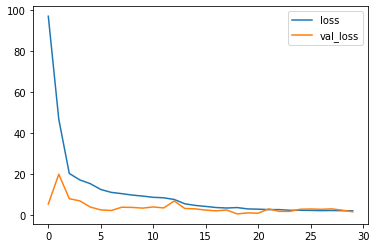

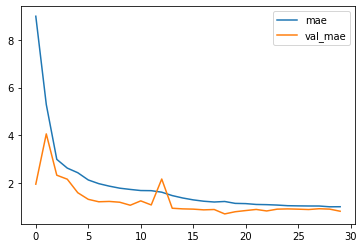

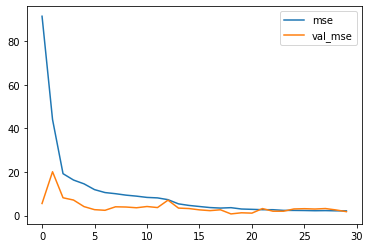

In [36]:
# call history
dh = pd.DataFrame(data=quantity_model.history.history)

# check learning rate and loss
dh.head();dh.tail()

# plot training vs validation
dh[['loss','val_loss']].plot()
dh[['mae','val_mae']].plot()
dh[['mse','val_mse']].plot()

8.203026232359155

11.242350514283656

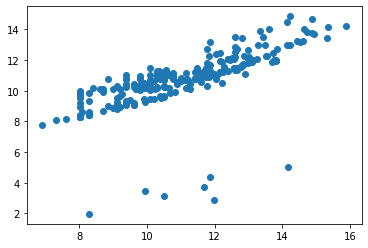

In [37]:
# Confirm performance using test data

# make prediction in scaled log of quantity 
y_pred_test = quantity_model.predict(X_test)

# compute array of differences between predictions and actuals
y_diff_test = abs(y_test - y_pred_test)

# compute percentage errors on y_test
y_percent_error_test = 100 * y_diff_test/y_test

# compute mean of percent error
y_percent_error_test.mean()

# compute deviation of percent error
y_percent_error_test.std()

# show scatter plot of error
plt.scatter(y_test,y_pred_test)

In [38]:
filepath = 'quantity_val_model'
save_model(quantity_model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: quantity_val_model/assets


In [39]:
from tensorflow.keras.backend import clear_session
clear_session()

### Retrain predictor with all data and epochs limited to early stopping point on validated training session

In [40]:
# Train the predictor using all of the data set except the reserved test set for final evaluation

# set the number of epochs from validation set model using early stopping

e = dh.val_loss.min()
e = dh.index[dh['val_loss']== e]
epochs = e[0]

# initiate callbacks

es = EarlyStopping(monitor='loss', patience=3, verbose=0,
    mode='auto', min_delta=.0005, restore_best_weights=True)

rlr = ReduceLROnPlateau(monitor='loss', factor=0.85,
                              mode = 'min', min_delta=.0005, patience=2, min_lr=0.0001)

mckp = ModelCheckpoint(filepath='win_all_checkpoint', monitor='loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch')


In [41]:
# Additional training on merged train and validation set with epochs limited to the min loss epoch on validation set
# when order_model is fit the second time, even with changed data, it loads the final weights from the first fit automatically
# clear_session does not reset the weights in the model and the learning rate starts at the last rlr learning rate

quantity_model.fit(X_all,y_all,
            batch_size=64,
            epochs=epochs,
            verbose=True,
            validation_data = None, sample_weight=all_weight,
            callbacks=[es,rlr])

Train on 4778 samples
Epoch 1/18
4778/4778 [==============================] - 10s 2ms/sample - loss: 2.2042 - mae: 1.0116 - mse: 2.0669
Epoch 2/18
4778/4778 [==============================] - 12s 3ms/sample - loss: 1.8304 - mae: 0.9722 - mse: 1.7084
Epoch 3/18
4778/4778 [==============================] - 12s 2ms/sample - loss: 1.8847 - mae: 0.9620 - mse: 1.7650
Epoch 4/18
4778/4778 [==============================] - 12s 3ms/sample - loss: 1.8860 - mae: 0.9584 - mse: 1.7687
Epoch 5/18
4778/4778 [==============================] - 13s 3ms/sample - loss: 1.7398 - mae: 0.9396 - mse: 1.6220
Epoch 6/18
4778/4778 [==============================] - 12s 3ms/sample - loss: 1.7534 - mae: 0.9261 - mse: 1.6482
Epoch 7/18
4778/4778 [==============================] - 13s 3ms/sample - loss: 1.8668 - mae: 0.9485 - mse: 1.7523
Epoch 8/18
4778/4778 [==============================] - 11s 2ms/sample - loss: 1.7559 - mae: 0.9386 - mse: 1.6451


In [42]:
# Save model for prediction

filepath = 'quantity_all_model'
save_model(quantity_model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

INFO:tensorflow:Assets written to: quantity_all_model/assets


In [43]:
# recover history
da = pd.DataFrame(data=quantity_model.history.history)

# check learning rates
da.head();da.tail()

,loss,mae,mse,lr
0,2.204202,1.011604,2.066913,0.00100
1,1.830368,0.972223,1.708377,0.00100
2,1.884685,0.962020,1.764955,0.00100
3,1.886005,0.958375,1.768717,0.00100
4,1.739752,0.939563,1.621954,0.00085


,loss,mae,mse,lr
3,1.886005,0.958375,1.768717,0.001000
4,1.739752,0.939563,1.621954,0.000850
5,1.753404,0.926119,1.648175,0.000850
6,1.866848,0.948451,1.752339,0.000850
7,1.755854,0.938630,1.645121,0.000723


1.32375352283014

8.321125319886356

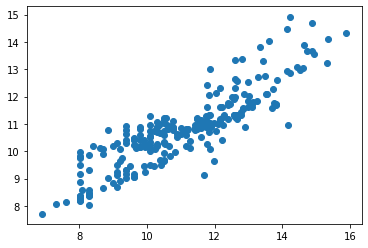

In [44]:
# Confirm performance using test data

# make prediction in scaled log of quantity 
y_pred_test = quantity_model.predict(X_test)

# compute array of differences between predictions and actuals
y_diff_test = y_test - y_pred_test

# compute percentage errors on y_test
y_percent_error_test = 100 * y_diff_test/y_test

# compute mean of percent error
y_percent_error_test.mean()

# compute deviation of percent error
y_percent_error_test.std()

# show scatter plot of error
plt.scatter(y_test,y_pred_test)

In [45]:
from tensorflow.keras.backend import clear_session
clear_session()
del quantity_model
gc.collect()

162936